# Load, Split, and Balance

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data.csv')

# drop rows with missing values
data = data.dropna()

#encode the string data as integers
label_encoder = LabelEncoder()
data['State'] = label_encoder.fit_transform(data['State'])
data['County'] = label_encoder.fit_transform(data['County'])

For now, we've decided to keep the county variable because by keeping the county variable, we could find patterns or trends specific to that county that would otherwise be lost if we removed the variable. However, since there are so many counties, it could make the model more complex and this could lead to overfitting. If it ends up causing overfitting, we'll consider removing it later.

### Balancing Dataset

We chose to use quantization thresholds for the ChildPoverty variable and divided them into 4 classes. By doing this, we ensure that each class has an approximately equal number of instances, which helps in balancing the dataset. Also, by using quantization thresholds we deal with the continuous variables by converting them into categorical variables, making them suitable for classification tasks.

We should only balance the training dataset because this ensures that model learns equally from all classes, preventing bias towards any particular class. We shouldn't balance the test dataset because it should  represent the real-world distribution of the data. Balancing the testing set would artificially alter the distribution of classes, leading to a bias in the model's performance.

In [2]:
from sklearn.model_selection import train_test_split

data['ChildPovertyClass'] = pd.qcut(data['ChildPoverty'], 4, labels=False)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['ChildPovertyClass'])

# Balance the training set
train_data = train_data.groupby('ChildPovertyClass').apply(lambda x: x.sample(train_data['ChildPovertyClass'].value_counts().min())).reset_index(drop=True)

## MLP 

Epoch: 100/100

Accuracy: 0.2495874587458746


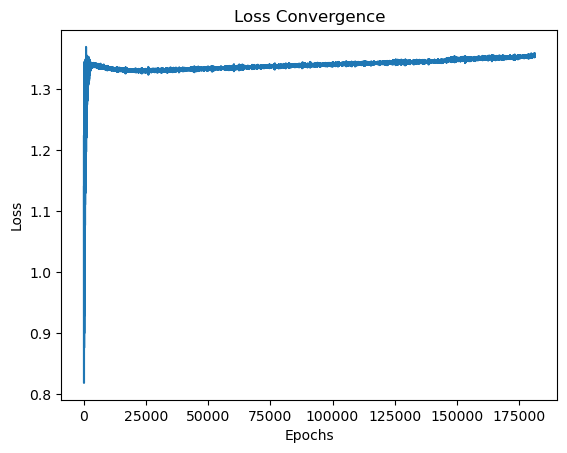

In [6]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## this code is taken directly from the Github
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        

    def _initialize_weights(self):
        """Initialize weights with Glorot."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_output_))
        W2 = np.random.uniform(-limit2, limit2, (self.n_output_, self.n_hidden))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y,W1,W2):
        '''Get the objective function value'''
        m = y.shape[0]
        y_expanded = np.zeros_like(A3)
        y_expanded[y, np.arange(m)] = 1
        
        # Binary cross-entropy for each class prediction
        log_probs = -y_expanded * np.log(A3) - (1 - y_expanded) * np.log(1 - A3)
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2).reshape(self.n_output_, -1)
        return A1, Z1, A2, Z2, A3
    
    def predict(self, X):
        """Predict class labels"""
        X = X.values
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0) if A3.shape[0] == self.n_output_ else np.argmax(A3.T, axis=1)
        return y_pred
    
    
 
            
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y, W1, W2):
        """ Compute gradient step using backpropagation.
        """

        m = Y.shape[0]
        Y_expanded = np.zeros_like(A3)
        Y_expanded[Y, np.arange(m)] = 1
        # vectorized backpropagation
        V2 = (A3 - Y_expanded) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        
        gradW2 = V2 @ A2.T / m
        gradW1 = V1 @ A1.T / m
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1)) / m
        gradb1 = np.sum(V1, axis=1).reshape((-1,1)) / m
        
        
        # regularize weights that are not bias terms
        gradW1 += self.l2_C * W1
        gradW2 += self.l2_C * W2
        return gradW1, gradW2, gradb1, gradb2
    
    def _initialize_weights(self):
        """Initialize weights with Glorot initialization."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        self.W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        self.b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_output_))
        self.W2 = np.random.uniform(-limit2, limit2, (self.n_output_, self.n_hidden))
        self.b2 = np.zeros((self.n_output_, 1))
        return self.W1, self.W2, self.b1, self.b2
    
    def _cost(self, A3, y, W1, W2):
        """Cross-entropy loss without one-hot encoding."""
        m = y.shape[0]
        log_probs = -np.log(A3[y, np.arange(m)])
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def fit(self, X, y, batch_size=32, print_progress=False):
        """Training without one-hot encoding"""
        X_data, y_data = X.values, y.values
        
        # Initialize weights
        self.n_features_ = X_data.shape[1]
        self.n_output_ = len(np.unique(y_data))  # Set output to number of classes
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        self.cost_ = []
        
        for i in range(self.epochs):
            indices = np.arange(X_data.shape[0])
            np.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[batch_idx], self.W1, self.W2, self.b1, self.b2)
                
                cost = self._cost(A3, y_data[batch_idx], self.W1, self.W2)
                self.cost_.append(cost)
                
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                                    Y=y_data[batch_idx], W1=self.W1, W2=self.W2)
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
            
            if print_progress and (i + 1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i + 1}/{self.epochs}')
                sys.stderr.flush()
                
        return self

X_train = train_data.drop(columns=['ChildPovertyClass'])
y_train = train_data['ChildPovertyClass']
X_test = test_data.drop(columns=['ChildPovertyClass'])
y_test = test_data['ChildPovertyClass']

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, batch_size=32, print_progress=50)
yhat = nn.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.show()

    